In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.dpi"] = 100

In [48]:
T = 0.05

a = 0
b = 1

h = 0.01
tau = 0.001

M = int(T/tau) + 1
N = int((b-a)/h) + 1

K = lambda u, x, t: np.sin(x*30) + 1.1

A = np.zeros((M, N))
Psi = np.ones(N-1)
Q = np.zeros(N)

Psis = [Psi.copy()]

for n in range(N):
    A[0][n] = np.sin(n*h)

for m in range(1, M):
    tau = 0.001
    for n in range(1, N - 1):
        Q[0] = 0
        for i in range(1, N-1):
            if A[m-1][i+1] == A[m-1][i-1]:
                Q[i] = 0
            else:
                Q[i] = (K(A[m-1][i+1], h*(i+1), tau*(m-1))*(A[m-1][i+1] - A[m-1][i]) - \
                        K(A[m-1][i-1], h*(i-1), tau*(m-1))*(A[m-1][i] - A[m-1][i-1])) * \
                        2/h/(Psi[i]+Psi[i-1])/(A[m-1][i+1] - A[m-1][i-1])
        Q[N-1] = 0
        
        Psi_next = np.zeros(N-1)
        
        taus = list()
        for i in range(0, N-1):
            if Q[i] != Q[i+1]:
                taus.append(abs(h*Psi[i]/2/(Q[i+1] - Q[i])))
        if len(taus) != 0:
            tau = min(taus)
        
        for i in range(0, N - 1):
            Psi_next[i] = Psi[i] + tau/h*(Q[i]-Q[i+1])
                
        A[m][n] = (A[m-1][n] * (Psi[n] + Psi[n-1]) / 2 + tau / h**2 * \
            (K((A[m-1][n+1] + A[m-1][n])/2, (n+1/2)*h, (m-1)*tau) / Psi[n] * (A[m-1][n+1]-A[m-1][n]) \
            - \
            K((A[m-1][n] + A[m-1][n-1])/2, (n-1/2)*h, (m-1)*tau) / Psi[n-1] * (A[m-1][n]-A[m-1][n-1])) \
            - \
            tau / (2*h) * (Q[n+1] * A[m-1][n+1] - Q[n-1]*A[m-1][n-1])) * 2 / (Psi_next[n]+Psi_next[n-1])

        Psi = np.copy(Psi_next)
        
        Psis.append(Psi.copy())
        

C:\Users\stas2\AppData\Local\Temp\ipykernel_4016\2500689728.py:51: RuntimeWarning: overflow encountered in double_scalars
  K((A[m-1][n] + A[m-1][n-1])/2, (n-1/2)*h, (m-1)*tau) / Psi[n-1] * (A[m-1][n]-A[m-1][n-1])) \
C:\Users\stas2\AppData\Local\Temp\ipykernel_4016\2500689728.py:31: RuntimeWarning: invalid value encountered in double_scalars
  Q[i] = (K(A[m-1][i+1], h*(i+1), tau*(m-1))*(A[m-1][i+1] - A[m-1][i]) - \
C:\Users\stas2\AppData\Local\Temp\ipykernel_4016\2500689728.py:46: RuntimeWarning: invalid value encountered in double_scalars
  Psi_next[i] = Psi[i] + tau/h*(Q[i]-Q[i+1])
C:\Users\stas2\AppData\Local\Temp\ipykernel_4016\2500689728.py:48: RuntimeWarning: invalid value encountered in double_scalars
  A[m][n] = (A[m-1][n] * (Psi[n] + Psi[n-1]) / 2 + tau / h**2 * \


In [50]:
Psi

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [ ]:
t = 0
for Psi in Psis:
    X = list()
    xi = 0
    X.append(xi)
    for psi in Psi:
        xi += psi * h
        X.append(xi)
    plt.scatter(X, np.full((len(X)), t), s=3, color='black')
    t += 0.01
plt.show()

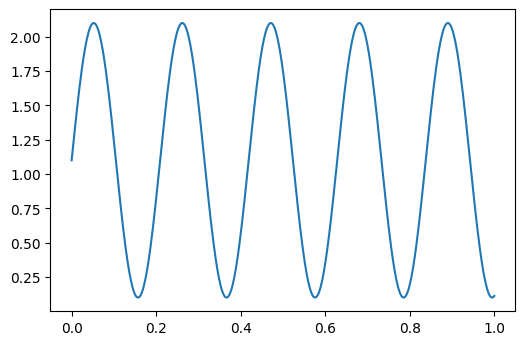

In [49]:


X = list()
xi = 0
for psi in Psi:
    xi += psi * h
    X.append(xi)
plt.scatter(X, np.full((len(X)), 0), s=3, color='black')
plt.plot(np.linspace(0, 1, 500), np.sin(np.linspace(0, 1, 500) * 30) + np.ones(500)*1.1)
plt.show()

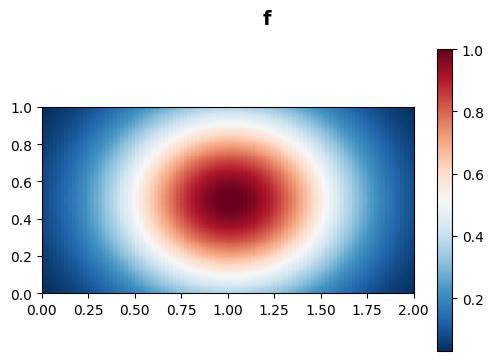

In [21]:
V = np.array([1, 1])
nx = np.array([1, 0])
ny = np.array([0, 1])
f = lambda x, y : np.exp(-((x-1)**2 + 10*(y-0.5)**2))
# K = lambda x, y : 1/f(x,y)

n = 100
extent = [0, 2, 0, 1]
noise = np.array([[f(i/n, j/n) for j in range(n)] for i in range(2*n)])

im = plt.imshow(noise, extent=extent, cmap='RdBu_r', interpolation='nearest')
plt.colorbar(im)
plt.gca().set_aspect('equal', adjustable='box')
plt.suptitle('f', fontsize=14, fontweight='bold')
plt.show()

x1, y1 = 0, 0
x2, y2 = 2, 1


x = (x1+x2)/2
y = (y1+y2)/2
for i in range(10):
    alphas = np.array([
        np.abs(x2-x) * f((x2+x)/2, y),
        np.abs(x-x1) * f((x1+x)/2, y),
        np.abs(y2-y) * f(x, (y2+y)/2),
        np.abs(y-y1) * f(x, (y+y1)/2)
    ])
    d = np.array([alphas[0]-alphas[1], alphas[2]-alphas[3]])


